<a href="https://colab.research.google.com/github/mrswjung/Subpixel-rendering-CNN/blob/main/CNN_for_diamond_shaped_PenTile_display_subpixel_rendering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN for diamond-shaped PenTile display subpixel rendering

mount drive to colab for loading local data to colab environmnet

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Datasets & DataLoaders

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir, makedirs, remove
from os.path import join, exists, basename
from PIL import Image
import cv2
import skimage
import skimage.io as imageio
from math import log10

### Loading a Dataset

In [ ]:
image_dir = "/content/gdrive/MyDrive/Colab Notebooks/DIV2K_train_HR"

Shape of 0001:
(1404, 2040, 3)


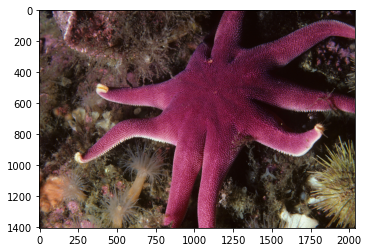

In [ ]:
DIV2K_train_0001 = imageio.imread('/content/gdrive/MyDrive/Colab Notebooks/DIV2K_train_HR/0001.png')
plt.imshow(DIV2K_train_0001)
print("Shape of 0001:")
print(DIV2K_train_0001.shape)

### Creating a Custom Dataset

In [ ]:
def is_image_file(filename):
  return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


def load_img(filepath):
  img = Image.open(filepath)
  return img

In [ ]:
class DatasetFromFolder(Dataset):
  def __init__(self, image_dir, input_transform=None, label_transform=None):
    super(DatasetFromFolder, self).__init__()
    self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]
    self.input_transform = input_transform
    self.label_transform = label_transform

  def __len__(self):

    return len(self.image_filenames)
    
  def __getitem__(self, idx):
    input = load_img(self.image_filenames[idx])
    label = input.copy()
    
    if self.input_transform:
      input = self.input_transform(input)
    if self.label_transform:
      label = self.label_transform(label)

    return input, label

In [ ]:
def img_transform(crop_size):
  return Compose([CenterCrop(crop_size),
                             ToTensor()
                             ])

Instantiate dataset class

In [ ]:
div2k_dataset = DatasetFromFolder(image_dir = image_dir,
                                  input_transform = img_transform(300),
                                  label_transform = img_transform(300))

Split dataset into training and validation sets

In [ ]:
len(div2k_dataset)

800

In [ ]:
train_size = int(0.8 * len(div2k_dataset))
test_size = len(div2k_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(div2k_dataset, [train_size, test_size])

In [ ]:
input_10, label_10 = train_dataset[10]
print(type(input_10))
print(type(input_10))
print(input_10.size())
print(label_10.size())
print(len(train_dataset), len(test_dataset))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([3, 300, 300])
torch.Size([3, 300, 300])
640 160


#### Iterating and Visualizing the Dataset

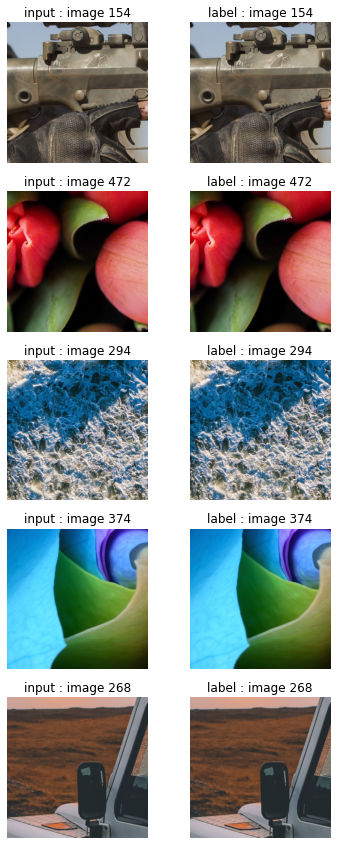

In [ ]:
transform = transforms.ToPILImage()

figure = plt.figure(figsize=(6, 15))
cols, rows = 2, 5
for i in range(1, cols*rows+1, 2):
  sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
  input, label = train_dataset[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(f"input : image {sample_idx}")
  plt.axis("off")
  input_img = transform(input)
  plt.imshow(input_img)
  figure.add_subplot(rows, cols, i+1)
  plt.title(f"label : image {sample_idx}")
  plt.axis("off")
  label_img = transform(label)
  plt.imshow(label_img)
plt.show()

#### Preparing the data for training with DataLoaders

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [ ]:
len(train_dataloader)

40

In [ ]:
train_images, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_images.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([16, 3, 300, 300])
Labels batch shape: torch.Size([16, 3, 300, 300])


#### Iterate through the DataLoader

## Building Models

#### Get Device for Training

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


#### Define the Class

Creat an instance of model / move the model to device / print its structure

In [ ]:
from torch import nn
import torch.nn.functional as F

In [ ]:
class SubPixelNet(nn.Module):
  def __init__(self, im_channels):
    super().__init__()
    self.conv1 = nn.Conv2d(im_channels, 128, kernel_size=7, padding=2)
    self.conv2 = nn.Conv2d(128, 128, kernel_size=1, padding=2, stride=2)
    self.convG = nn.Conv2d(128, 1, kernel_size=6, padding=2)
    self.convR1 = nn.Conv2d(128, 1, kernel_size=6, padding=2, stride=2)
    self.convR2 = nn.Conv2d(128, 1, kernel_size=6, padding=2, stride=2)
    self.convB1 = nn.Conv2d(128, 1, kernel_size=6, padding=2, stride=2)
    self.convB2 = nn.Conv2d(128, 1, kernel_size=6, padding=2, stride=2)    

  def forward(self, x):
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))

    G = self.convG(out)
    R1 = self.convR1(out)
    R2 = self.convR2(out)
    B1 = self.convB1(out)
    B2 = self.convB2(out)
    
    mask_G = torch.tensor([
            [1, 0],
            [0, 0], 
        ])
    mask_R1 = torch.tensor([
            [0, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
        ])

    mask_R2 = torch.tensor([
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 1],
        ])

    mask_B1 = torch.tensor([
            [0, 0, 0, 0],
            [0, 0, 0, 1],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
        ])

    mask_B2 = torch.tensor([
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 1, 0, 0],
        ])
  
    mask_G = mask_G.view(1,1,2,2).float()
    mask_R1 = mask_R1.view(1,1,4,4).float()
    mask_R2 = mask_R2.view(1,1,4,4).float()
    mask_B1 = mask_B1.view(1,1,4,4).float()
    mask_B2 = mask_B2.view(1,1,4,4).float()

    mask_G = mask_G.to(device)
    mask_R1 = mask_R1.to(device)
    mask_R2 = mask_R2.to(device)
    mask_B1 = mask_B1.to(device)
    mask_B2 = mask_B2.to(device)
        
    g = F.conv_transpose2d(G, mask_G, stride=2, padding=0)
    r1 = F.conv_transpose2d(R1, mask_R1, stride=4, padding=0)
    r2 = F.conv_transpose2d(R2, mask_R2, stride=4, padding=0)
    b1 = F.conv_transpose2d(B1, mask_B1, stride=4, padding=0)
    b2 = F.conv_transpose2d(B2, mask_B2, stride=4, padding=0)
        
    r, b = torch.add(r1,r2), torch.add(b1,b2)
       
    weights_G = torch.tensor([
            [0.25, 0.5, 0.25],
            [ 0.5,   1,  0.5],
            [0.25, 0.5, 0.25],   
        ])
        
    weights_RB = torch.tensor([
            [   0,    0,    0, 0.06,    0,    0,    0],
            [   0,    0, 0.19, 0.25, 0.19,    0,    0],
            [   0, 0.19,  0.5, 0.56,  0.5, 0.19,    0],
            [0.06, 0.25, 0.56,  1.0, 0.56, 0.25, 0.06],
            [   0, 0.19,  0.5, 0.56,  0.5, 0.19,    0],
            [   0,    0, 0.19, 0.25, 0.19,    0,    0],
            [   0,    0,    0, 0.06,    0,    0,    0],
        ])

    weights_G = weights_G.view(1,1,3,3).float()
    weights_RB = weights_RB.view(1,1,7,7).float()
        
    weights_G = weights_G.to(device)
    weights_RB = weights_RB.to(device)
        
    g = F.conv2d(g, weights_G, None, 1, 1)
    r = F.conv2d(r, weights_RB, None, 1, 3)
    b = F.conv2d(b, weights_RB, None, 1, 3)
        
    outputs = torch.cat((r,g,b), dim=1)
     
    return outputs

In [ ]:
Net = SubPixelNet(im_channels=3).to(device)
print(Net)

SubPixelNet(
  (conv1): Conv2d(3, 128, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(128, 128, kernel_size=(1, 1), stride=(2, 2), padding=(2, 2))
  (convG): Conv2d(128, 1, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
  (convR1): Conv2d(128, 1, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
  (convR2): Conv2d(128, 1, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
  (convB1): Conv2d(128, 1, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
  (convB2): Conv2d(128, 1, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
)


In [ ]:
X = torch.rand(3, 100, 100, device=device).unsqueeze(0)
output = Net(X)
print(X.shape)
print(output.shape)

torch.Size([1, 3, 100, 100])
torch.Size([1, 3, 100, 100])


## Optimizing Model Parameteres 

#### Hyperparameteres


Number of Epochs - the number times to iterate over the dataset

Batch Size - the number of data samples propagated through the network before the parameters are updated

Learning Rate - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [ ]:
learning_rate = 1e-3
batch_size = 16
epochs = 100

### Optimization Loop

Loss function

In [ ]:
loss_fn = nn.MSELoss()

Optimizer 

In [ ]:
optimizer = torch.optim.SGD(Net.parameters(), lr = learning_rate)

#### Full Implementation

training loop

In [ ]:
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader) #40
  epoch_loss = 0
  epoch_psnr = 0 
  for batch, (X, Y) in enumerate(dataloader, 1):
    
    #Compute prediction and training loss
    input, target = X.to(device), Y.to(device)
    output = Net(input)
    loss = loss_fn(output, target)
    epoch_loss += loss.item()
    psnr = 10*log10(1/loss.item())
    epoch_psnr += psnr

    #Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 20 == 0:
      print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, batch, size, loss.item()))

  print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / size))
  train_loss.append(epoch_loss / size)
  train_psnr.append(epoch_psnr / size)

test loop

In [ ]:
def test(dataloader, model, loss_fn):
  size = len(dataloader)
  epoch_loss = 0
  epoch_psnr = 0
  with torch.no_grad():
    for X, Y in test_dataloader:

      #Compute prediction and validation loss
      input, target = X.to(device), Y.to(device)
      output = Net(input)
      loss = loss_fn(output, target)
      epoch_loss += loss.item()
      psnr = 10*log10(1/loss.item())
      epoch_psnr += psnr
            
    print("===> Avg. PSNR: {:.4f} dB".format(epoch_psnr / size))
    val_loss.append(epoch_loss / size)
    val_psnr.append(epoch_psnr / size)

In [ ]:
def checkpoint(epoch):
  if epoch % 10 == 0:
    model_out_path = "model_epoch_{}.pth".format(epoch)
    torch.save(Net, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

model training


In [ ]:
for epoch in range(1, epochs + 1):
  print(f"Epoch {epoch}\n-------------------------------")
  train(train_dataloader, Net, loss_fn, optimizer)
  test(test_dataloader, Net, loss_fn)
  checkpoint(epoch)

Epoch 1
-------------------------------
===> Epoch[1](20/40): Loss: 0.1367
===> Epoch[1](40/40): Loss: 0.1026
===> Epoch 1 Complete: Avg. Loss: 0.1822
===> Avg. PSNR: 9.9733 dB
Epoch 2
-------------------------------
===> Epoch[2](20/40): Loss: 0.0630
===> Epoch[2](40/40): Loss: 0.0429
===> Epoch 2 Complete: Avg. Loss: 0.0640
===> Avg. PSNR: 13.6473 dB
Epoch 3
-------------------------------
===> Epoch[3](20/40): Loss: 0.0278
===> Epoch[3](40/40): Loss: 0.0262
===> Epoch 3 Complete: Avg. Loss: 0.0337
===> Avg. PSNR: 15.3885 dB
Epoch 4
-------------------------------
===> Epoch[4](20/40): Loss: 0.0235
===> Epoch[4](40/40): Loss: 0.0244
===> Epoch 4 Complete: Avg. Loss: 0.0266
===> Avg. PSNR: 15.9349 dB
Epoch 5
-------------------------------
===> Epoch[5](20/40): Loss: 0.0285
===> Epoch[5](40/40): Loss: 0.0253
===> Epoch 5 Complete: Avg. Loss: 0.0249
===> Avg. PSNR: 16.0658 dB
Epoch 6
-------------------------------
===> Epoch[6](20/40): Loss: 0.0291
===> Epoch[6](40/40): Loss: 0.0213
=

train_loss

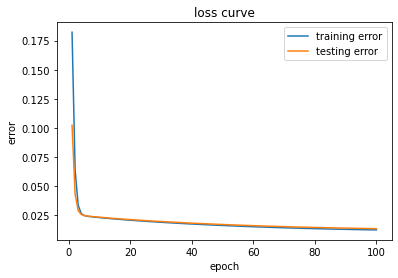

In [ ]:
x = list(range(1, epochs+1))

fig, ax = plt.subplots()
ax.plot(x, train_loss, label='training error')
ax.plot(x, val_loss, label='testing error')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.set_title("loss curve")
ax.legend();

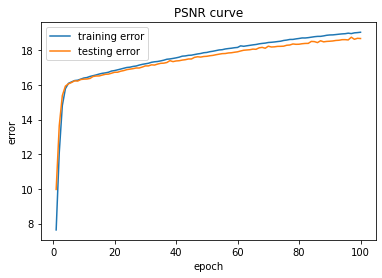

In [ ]:
x = list(range(1, epochs+1))

fig, ax = plt.subplots()
ax.plot(x, train_psnr, label='training error')
ax.plot(x, val_psnr, label='testing error')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.set_title("PSNR curve")
ax.legend();

## Save and Load the Model

In [ ]:
torch.save(Net, 'model_epoch_100.pth')

In [ ]:
model = torch.load('model_epoch_100.pth')

## Evaluate Model Performance

Shape of test_image:
(512, 512, 3)


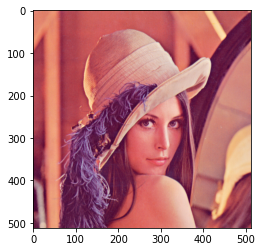

In [ ]:
test_image = imageio.imread('/content/gdrive/MyDrive/Colab Notebooks/lena_std.tif')
plt.imshow(test_image)
print("Shape of test_image:")
print(test_image.shape)

In [ ]:
def Diamond_PenTile_Virtual(image):
    with torch.no_grad():
      img_to_tensor = ToTensor()
      img_data = img_to_tensor(image).unsqueeze(0)
      img_data = img_data.to(device)
      img_data = model(img_data)
      img_data = img_data.cpu()
      img_data = img_data.squeeze()    
    return img_data

In [ ]:
lenna_virtual = Diamond_PenTile_Virtual(test_image)
lenna_virtual.shape

torch.Size([3, 512, 512])

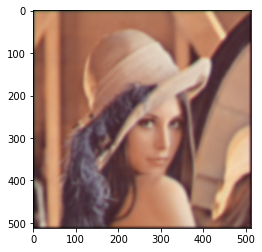

In [ ]:
transform = transforms.ToPILImage()
lenna = transform(lenna_virtual)
plt.imshow(lenna)

In [ ]:
virtual_lenna = lenna.save("virtual_lenna.tif")

In [ ]:
img1 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/lena_std.tif")
img2 = cv2.imread("virtual_lenna.tif")
cv2.PSNR(img1, img2)

20.211880719274884